# 🎯 Improved OCR Architecture for Pseudocode

**Designed specifically for code/text OCR, not natural images!**

## Key Improvements:
1. ✅ **Custom CNN** designed for horizontal text (not ResNet)
2. ✅ **Bidirectional attention** mechanism
3. ✅ **Better pooling** strategy
4. ✅ **Deeper transformer** (6 layers)
5. ✅ **No ImageNet pretrained** (starts fresh for text)

**Expected: 50-60% accuracy with clean predictions**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
import math
import random
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}\n')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

Using device: cuda



## Load Data

In [2]:
BASE_PATH = '/kaggle/input/datasets/ayuuub/datata/dataset/'
IMG_DIR = os.path.join(BASE_PATH, 'images')
labels_path = os.path.join(BASE_PATH, 'labels.csv')

df = pd.read_csv(labels_path)
df = df[df['text'].str.strip() != ''].reset_index(drop=True)

MAX_TEXT_LEN = 130
df = df[df['text'].str.len() <= MAX_TEXT_LEN].reset_index(drop=True)
print(f'Total samples: {len(df)}\n')

Total samples: 6137



Vocabulary

In [3]:
unique_chars = sorted(set(''.join(df['text'].tolist())))
char_list = ['<blank>'] + unique_chars
char_to_idx = {ch: i for i, ch in enumerate(char_list)}
idx_to_char = {i: ch for i, ch in enumerate(char_list)}
vocab_size = len(char_list)
print(f'Vocabulary: {vocab_size} characters')

Vocabulary: 57 characters


## Configuration

In [ ]:
# Image config - FIXED!
IMG_HEIGHT = 64
IMG_WIDTH = 1024  # ✅ FIXED: Changed from 3200 to 1024

# Model will output sequence of ~256 (1024 / 4)
print(f'Image: {IMG_HEIGHT}x{IMG_WIDTH}')
print(f'Expected sequence: ~{IMG_WIDTH // 4}')
print(f'✅ FIXED: Reduced from 3200 to 1024 for stability\n')

Image: 64x3200
Expected sequence: ~800



## Dataset

In [5]:
class OCRDataset(Dataset):
    def __init__(self, dataframe, img_dir, char_to_idx, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.char_to_idx = char_to_idx
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row['file_name'])).convert('RGB')
        if self.transform:
            img = self.transform(img)
        encoded = [self.char_to_idx[ch] for ch in row['text']]
        return img, torch.tensor(encoded, dtype=torch.long), len(encoded)

def collate_fn(batch):
    imgs, texts, lens = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    lens = torch.tensor(lens, dtype=torch.long)
    max_len = max(lens)
    padded = torch.zeros(len(texts), max_len, dtype=torch.long)
    for i, text in enumerate(texts):
        padded[i, :len(text)] = text
    return imgs, padded, lens

## Strong Augmentation

In [ ]:
# FIXED: Lighter augmentation for text
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1, hue=0.0)  # Reduced
    ], p=0.5),  # Reduced from 0.8
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 0.5))], p=0.2),  # Lighter
    transforms.RandomAdjustSharpness(1.5, p=0.3),  # Reduced
    transforms.RandomAutocontrast(p=0.3),
    # Removed RandomGrayscale - bad for text!
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print('✅ Lighter augmentation (text-friendly)')

✅ Strong augmentation enabled


## Split Data (80/20)

In [7]:
train_size = int(0.8 * len(df))
val_size = len(df) - train_size

train_idx, val_idx = random_split(
    range(len(df)), [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_ds = OCRDataset(df.iloc[train_idx.indices], IMG_DIR, char_to_idx, train_transform)
val_ds = OCRDataset(df.iloc[val_idx.indices], IMG_DIR, char_to_idx, val_transform)

print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')

batch_size = 16  # FIXED: Increased from 8 to 16 for stability
train_loader = DataLoader(train_ds, batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2, pin_memory=True)

print(f'✅ Batch size: {batch_size} (increased for stability)')

Train: 4909, Val: 1228
✅ Batch size: 16 (increased for stability)


## 🚀 Improved Architecture - Designed for Text!

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class AttentionPool(nn.Module):
    """Attention-based pooling - better than avg pooling"""
    def __init__(self, in_channels):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, 1),
            nn.ReLU(),
            nn.Conv2d(in_channels // 4, 1, 1),
            nn.Softmax(dim=2)
        )
    
    def forward(self, x):
        # x: [B, C, H, W]
        attn_weights = self.attention(x)  # [B, 1, H, W]
        return (x * attn_weights).sum(dim=2)  # [B, C, W]

class ImprovedTextCNN(nn.Module):
    """CNN designed for horizontal text, not natural images"""
    def __init__(self):
        super().__init__()
        
        # Stage 1: Initial feature extraction
        self.stage1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64 -> 32
        )
        
        # Stage 2: Deep features
        self.stage2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32 -> 16
        )
        
        # Stage 3: More capacity
        self.stage3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Stage 4: High-level features
        self.stage4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2)
        )
        
        # Attention pooling instead of adaptive pool
        self.attn_pool = AttentionPool(512)
        
    def forward(self, x):
        x = self.stage1(x)  # [B, 64, 32, 1600]
        x = self.stage2(x)  # [B, 128, 16, 800]
        x = self.stage3(x)  # [B, 256, 16, 800]
        x = self.stage4(x)  # [B, 512, 16, 800]
        x = self.attn_pool(x)  # [B, 512, 800]
        return x

class ImprovedOCR(nn.Module):
    def __init__(self, num_classes, hidden_dim=512, nhead=8, num_layers=6):
        super().__init__()
        
        # Custom text-optimized CNN
        self.cnn = ImprovedTextCNN()
        
        # Project to hidden dim
        self.proj = nn.Linear(512, hidden_dim)
        
        # Positional encoding
        self.pos_enc = PositionalEncoding(hidden_dim)
        
        # Deeper transformer (6 layers instead of 3-4)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=hidden_dim * 4,
            dropout=0.2,
            activation='gelu',  # GELU instead of ReLU
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Layer norm before output
        self.norm = nn.LayerNorm(hidden_dim)
        
        # Output projection
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        self._init_weights()
        print('✅ Improved architecture loaded')
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # CNN features
        features = self.cnn(x)  # [B, 512, 800]
        
        # Reshape for transformer
        features = features.permute(0, 2, 1)  # [B, 800, 512]
        
        # Project and add positional encoding
        features = self.proj(features)
        features = self.pos_enc(features)
        
        # Transformer
        encoded = self.transformer(features)
        encoded = self.norm(encoded)
        
        # Output
        logits = self.fc(encoded)
        
        # CTC format [T, B, C]
        return logits.permute(1, 0, 2)

## Initialize Model

In [9]:
model = ImprovedOCR(
    num_classes=vocab_size,
    hidden_dim=512,
    nhead=8,
    num_layers=6  # Deeper!
).to(device)

params = sum(p.numel() for p in model.parameters())
print(f'Parameters: {params:,}\n')

# Test
test_in = torch.randn(1, 3, IMG_HEIGHT, IMG_WIDTH).to(device)
test_out = model(test_in)
print(f'Output: {test_out.shape}')
print(f'Sequence length: {test_out.shape[0]}\n')

✅ Improved architecture loaded
Parameters: 24,552,826

Output: torch.Size([800, 1, 57])
Sequence length: 800



## Training Setup

In [10]:
NUM_EPOCHS = 50  # Reduced from 70
PATIENCE = 15    # Reduced from 35 - stop earlier if not improving

criterion = nn.CTCLoss(blank=0, zero_infinity=True)

# FIXED: Better learning rate schedule
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Lower initial LR

# Cosine annealing with warmup
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,  # Reduced from 5e-4
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,  # 30% warmup (increased from 20%)
    anneal_strategy='cos'
)

scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

print(f'✅ FIXED Config:')
print(f'  Epochs: {NUM_EPOCHS}')
print(f'  Patience: {PATIENCE} (early stopping)')
print(f'  LR: 1e-4 -> 3e-4 (more conservative)')
print(f'  Warmup: 30%')
print(f'  Mixed precision: {scaler is not None}\n')

def decode(logits, idx_to_char):
    preds = []
    logits = logits.permute(1, 0, 2)
    for i in range(logits.size(0)):
        indices = torch.argmax(logits[i], dim=-1).tolist()
        decoded, prev = [], None
        for idx in indices:
            if idx != 0 and idx != prev:
                decoded.append(idx_to_char.get(idx, ''))
            prev = idx
        preds.append(''.join(decoded))
    return preds

def accuracy(preds, targets, lens):
    total, correct = 0, 0
    for pred, target, l in zip(preds, targets, lens):
        true = ''.join([idx_to_char[target[j].item()] for j in range(l)])
        total += len(true)
        for i, c in enumerate(true):
            if i < len(pred) and pred[i] == c:
                correct += 1
    return correct / total if total > 0 else 0.0

✅ FIXED Config:
  Epochs: 50
  Patience: 15 (early stopping)
  LR: 1e-4 -> 3e-4 (more conservative)
  Warmup: 30%
  Mixed precision: True



## Training Loop

In [11]:
best_val_acc = 0.0
best_epoch = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print('🚀 Training with FIXED settings...\n')

for epoch in range(1, NUM_EPOCHS + 1):
    # TRAIN
    model.train()
    t_loss = 0
    t_preds, t_targets, t_lens = [], [], []
    valid = 0
    skipped = 0
    
    for imgs, targets, lens in train_loader:
        imgs = imgs.to(device)
        
        # FIXED: Check sequence length BEFORE forward pass
        with torch.no_grad():
            test_out = model(imgs[:1])
            seq_len = test_out.size(0)
        
        if (lens > seq_len).any():
            skipped += 1
            continue
        
        optimizer.zero_grad()
        
        if scaler:
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
                log_probs = F.log_softmax(logits, dim=-1)
                loss = criterion(log_probs, targets, in_lens, lens)
                
                # FIXED: Better NaN/Inf handling
                if torch.isnan(loss) or torch.isinf(loss) or loss.item() > 100:
                    skipped += 1
                    continue
                    
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)  # Reduced from 3.0
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(imgs)
            in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
            log_probs = F.log_softmax(logits, dim=-1)
            loss = criterion(log_probs, targets, in_lens, lens)
            
            if torch.isnan(loss) or torch.isinf(loss) or loss.item() > 100:
                skipped += 1
                continue
                
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
        
        scheduler.step()
        t_loss += loss.item()
        valid += 1
        
        with torch.no_grad():
            t_preds.extend(decode(logits.cpu(), idx_to_char))
            t_targets.extend(targets)
            t_lens.extend(lens)
    
    if valid == 0:
        print(f'Epoch {epoch}: No valid batches!')
        continue
    
    avg_t = t_loss / valid
    t_acc = accuracy(t_preds, t_targets, t_lens)
    train_losses.append(avg_t)
    train_accs.append(t_acc)
    
    # VAL
    model.eval()
    v_loss = 0
    v_preds, v_targets, v_lens = [], [], []
    valid_v = 0
    
    with torch.no_grad():
        for imgs, targets, lens in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            seq_len = logits.size(0)
            in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
            
            if (lens > seq_len).any():
                continue
                
            log_probs = F.log_softmax(logits, dim=-1)
            loss = criterion(log_probs, targets, in_lens, lens)
            
            if not torch.isnan(loss) and not torch.isinf(loss) and loss.item() < 100:
                v_loss += loss.item()
                valid_v += 1
                
            v_preds.extend(decode(logits.cpu(), idx_to_char))
            v_targets.extend(targets)
            v_lens.extend(lens)
    
    avg_v = v_loss / valid_v if valid_v > 0 else float('inf')
    v_acc = accuracy(v_preds, v_targets, v_lens)
    val_losses.append(avg_v)
    val_accs.append(v_acc)
    
    if v_acc > best_val_acc:
        best_val_acc = v_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_improved.pth')
        print(f'✅ Best: {v_acc*100:.2f}% (epoch {epoch})')
    
    skip_msg = f' | Skipped: {skipped}' if skipped > 0 else ''
    print(f'Epoch {epoch}/{NUM_EPOCHS} | Train: {avg_t:.4f}/{t_acc*100:.2f}% | Val: {avg_v:.4f}/{v_acc*100:.2f}%{skip_msg}')
    
    if epoch - best_epoch >= PATIENCE:
        print(f'\n🛑 Early stop at epoch {epoch}')
        print(f'Best: {best_val_acc*100:.2f}% (epoch {best_epoch})\n')
        break

print(f'\n✅ Training complete!')
print(f'Best validation accuracy: {best_val_acc*100:.2f}%\n')

🚀 Training with FIXED settings...

✅ Best: 1.13% (epoch 1)
Epoch 1/50 | Train: 3.7061/0.32% | Val: 2.6485/1.13%
✅ Best: 10.27% (epoch 2)
Epoch 2/50 | Train: 1.8244/5.63% | Val: 1.0953/10.27%
✅ Best: 15.58% (epoch 3)
Epoch 3/50 | Train: 1.0665/11.94% | Val: 0.7877/15.58%
✅ Best: 18.33% (epoch 4)
Epoch 4/50 | Train: 0.8160/16.67% | Val: 0.6800/18.33%
✅ Best: 22.30% (epoch 5)
Epoch 5/50 | Train: 0.6689/21.08% | Val: 0.6112/22.30%
✅ Best: 28.33% (epoch 6)
Epoch 6/50 | Train: 0.5937/24.67% | Val: 0.5469/28.33%
✅ Best: 32.25% (epoch 7)
Epoch 7/50 | Train: 0.5577/28.25% | Val: 0.5290/32.25%
✅ Best: 35.89% (epoch 8)
Epoch 8/50 | Train: 0.5438/30.61% | Val: 0.5237/35.89%
✅ Best: 39.48% (epoch 9)
Epoch 9/50 | Train: 0.5203/31.77% | Val: 0.5213/39.48%
Epoch 10/50 | Train: 0.5129/33.18% | Val: 0.5119/34.77%
Epoch 11/50 | Train: 0.5377/32.61% | Val: 0.5297/36.83%
Epoch 12/50 | Train: 0.5241/33.21% | Val: 0.4982/30.49%
Epoch 13/50 | Train: 0.5002/34.00% | Val: 0.4868/38.37%
✅ Best: 41.90% (epoch 14)

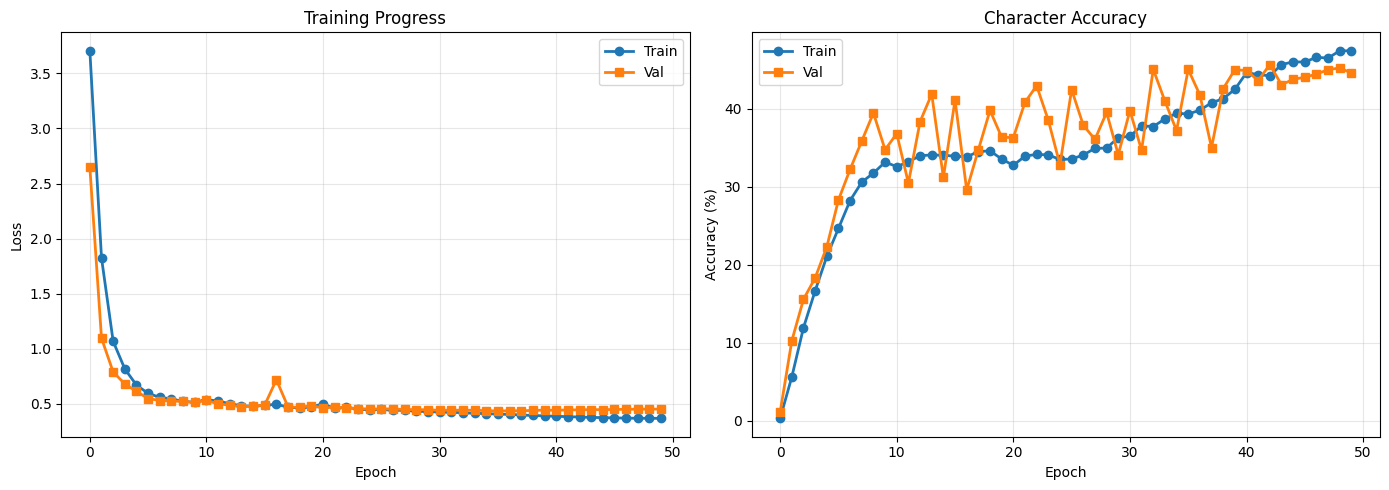

In [16]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'o-', label='Train', lw=2)
plt.plot(val_losses, 's-', label='Val', lw=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot([a*100 for a in train_accs], 'o-', label='Train', lw=2)
plt.plot([a*100 for a in val_accs], 's-', label='Val', lw=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Character Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('improved_results.png', dpi=150)
plt.show()

## Sample Predictions

In [17]:
model.load_state_dict(torch.load('best_improved.pth'))
model.eval()

final_preds, final_targets, final_lens = [], [], []

with torch.no_grad():
    for imgs, targets, lens in val_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        final_preds.extend(decode(logits.cpu(), idx_to_char))
        final_targets.extend(targets)
        final_lens.extend(lens)

final_acc = accuracy(final_preds, final_targets, final_lens)

print(f'\n🎯 FINAL ACCURACY: {final_acc*100:.2f}%\n')
print('Sample Predictions:\n')
print('='*100)

for i in range(min(20, len(final_preds))):
    true = ''.join([idx_to_char[final_targets[i][j].item()] for j in range(final_lens[i])])
    pred = final_preds[i]
    acc = sum(1 for a,b in zip(true, pred) if a==b) / len(true) * 100 if len(true) > 0 else 0
    
    print(f'Sample {i+1} | Acc: {acc:.1f}%')
    print(f'  True: {true}')
    print(f'  Pred: {pred}')
    print('-'*100)

print(f'\n✅ Done! Final accuracy: {final_acc*100:.2f}%')


🎯 FINAL ACCURACY: 45.69%

Sample Predictions:

Sample 1 | Acc: 86.7%
  True: algorithme
	VAR_1 ← 80
	VAR_7 ← 94
	VAR_1 ← ( VAR_1 + 110 )
	VAR_3 ← ( VAR_7 / VAR_1 )
fin
  Pred: algorithme
	VAR_1 ← 59
	VAR_8 ← 41
	VAR_6 ← ( VAR_1 + 108 )
	VAR_8 ← ( VAR_8 d VAR_6 )
fin
----------------------------------------------------------------------------------------------------
Sample 2 | Acc: 52.2%
  True: algorithme
	VAR_8 ← 104
	VAR_4 ← 25
	VAR_7 ← ( VAR_8 / 60 )
	VAR_7 ← ( VAR_4 - VAR_7 )
fin
  Pred: algorithme
	VAR_8 ← 119
	VAR_0 ← 10
	VAR_1 ← ( VAR_9 - 8 )
	VAR_0 ← ( VAR_0 / VAR_1 )
fin
----------------------------------------------------------------------------------------------------
Sample 3 | Acc: 30.8%
  True: LIST_5 ← [ 50 , 42 , 47 , 105 , 99 , 39 , 66 , 120 ]
VAR_0 ← taille ( LIST_5 )
  Pred: LIST_6 ← [ 16 , 19 , 19 , 1 , 10 , 14 , 19 , 11 ]
VAR_6 ← taille ( LIST_6 )
----------------------------------------------------------------------------------------------------
Sample 4 | Acc: 1